## Importing Libraries

In [1]:
import numpy as np
import pandas as pd

## Dataset Calling

In [10]:
model_final = pd.read_excel("Model_Final_Data.xlsx",engine="openpyxl",index_col="Unnamed: 0")
model_final.head()

,Identifier,DRL_Win_Flag,Form,Region,Tender_Type,Client,#Participant,Winning_Price,Proximity_Delivery,Tender_Duration,Previous_Winning_Price,#Months_G.E,DRL_Bid_price,Prv_Cat
0,CINACALCET 30MG84724,0,1,3,1,2,2,0.36800,0.266667,1.106742,0.36800,0.466667,1.0000,0
1,CINACALCET 30MG85261,0,1,2,2,2,2,0.41587,0.266667,0.769663,0.36800,0.933333,1.2144,0
2,CINACALCET 30MG85386,1,1,3,2,1,1,0.67860,0.533333,1.794944,0.41587,1.100000,0.6786,0
4,CINACALCET 60MG84724,0,1,3,1,2,2,0.67900,0.266667,1.106742,0.67900,0.466667,2.5000,0
5,CINACALCET 60MG85261,0,1,2,2,2,2,0.54609,0.266667,0.769663,0.67900,0.933333,2.1070,0


## Price Prediction

### Gradient Boosting Regressor

#### Importing Libraries

In [6]:
from sklearn.ensemble import GradientBoostingRegressor

#### Setting up the Variables

In [118]:
X_cols = ["Client",' Tender_Type','Proximity_Delivery', '#Participant',
       'Tender_Duration',"Previous_Winning_Price", '#Months_G.E']
X = model_final[X_cols]
Y = list(model_final["Winning_Price"])

### Checking up the Variance Inflation Score

In [119]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
norm_X = X.apply(lambda iterator: ((iterator-iterator.mean())/iterator.std()).round(2))
norm_X
vif_data = pd.DataFrame()
vif_data["Feature"]=norm_X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values , i) for i in range(len(norm_X.columns))]
vif_data

,Feature,VIF
0,Client,12.958465
1,Tender_Type,10.313807
2,Proximity_Delivery,2.760251
3,#Participant,16.975320
4,Tender_Duration,9.341480
5,Previous_Winning_Price,1.619312
6,#Months_G.E,2.705417


#### Mean Absolute Percentage error formulation

In [120]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#### Fitting

In [121]:
grad_reg = GradientBoostingRegressor(random_state=0)
grad_reg.fit(X,np.log(Y))
mean_absolute_percentage_error(Y,np.exp(grad_reg.predict(X)))

9.973114128329641

### Fitting Visualisation

<AxesSubplot:xlabel='Winning_Price', ylabel='Density'>

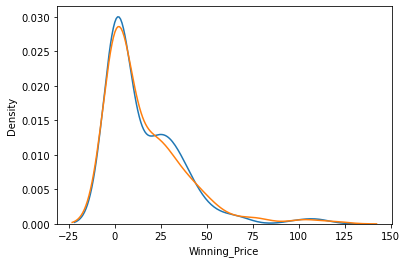

In [15]:
import seaborn as sns
sns.kdeplot(list(np.exp(grad_reg.predict(X))))
sns.kdeplot(model_final["Winning_Price"])

### Interval Estimation

In [28]:
model_final["Predictions"] = np.exp(grad_reg.predict(X))
model_final["Deviation"] = np.abs(model_final["Winning_Price"]-model_final["Predictions"])

### Getting the nearesr like Distribution

,sumsquare_error,aic,bic,kl_div
lognorm,2.204835,816.067830,-712.624372,inf
gamma,4.251351,1050.125326,-602.318283,inf
norm,12.938359,859.929669,-420.465012,inf


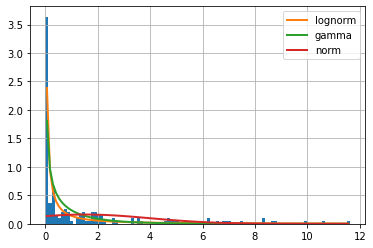

In [29]:
from fitter import Fitter
f = Fitter(model_final["Deviation"],
           distributions=['gamma',
                         "lognorm",
                         "norm"])
f.fit()
f.summary()

**Log Normal Distribution** fits the best thus we will fit the data on it and go for interval estimation.

In [31]:
from scipy.stats import lognorm

In [49]:
def dist_std(df):
    left_inter = 0.80
    std1 = []
    left1=[]
    right1 = []
    for i in (df["Prv_Cat"]).unique():
        prv_df = df[df["Prv_Cat"]==i]
        res = pd.Series(np.abs(prv_df["Winning_Price"]-prv_df["Predictions"]))
        std1.append(np.std(res))
        right = lognorm.interval((1-left_inter),lognorm.fit(res))/np.sqrt(len(prv_df))
        left = lognorm.interval(left_inter,lognorm.fit(res))/np.sqrt(len(prv_df))
        left1.append(left[0][0])
        right1.append(right[0][0])
        #sns.kdeplot(res)
    return pd.DataFrame({"Category":(df["Prv_Cat"]).unique(),"Standard":std1,"Left":left1,"Right":right1})

In [50]:
cat_df = dist_std(model_final)
cat_df

,Category,Standard,Left,Right
0,0,0.122222,0.024168,0.097428
1,1,2.150848,0.011577,0.066374
2,2,3.531955,0.097524,0.193723


In [51]:
upper = []
lower = []
for i in range(len(model_final)):
    cat = model_final.iloc[i]["Prv_Cat"]
    lower.append(model_final.iloc[i]["Predictions"]-6*cat_df["Left"][cat]*cat_df["Standard"][cat])
    upper.append(model_final.iloc[i]["Predictions"]+8*cat_df["Right"][cat]*cat_df["Standard"][cat])

In [52]:
pd.DataFrame({"Upper":upper,"Actual":list(model_final["Winning_Price"]),"Lower":lower})

,Upper,Actual,Lower
0,0.481977,0.36800,0.368992
1,0.490849,0.41587,0.377863
2,0.876039,0.67860,0.763054
3,0.708678,0.67900,0.595693
4,0.709889,0.54609,0.596903
...,...,...,...
163,10.775079,13.33334,9.483587
164,0.322434,0.26990,0.209449
165,0.357660,0.24550,0.244674
166,0.301117,0.18020,0.188131


In [53]:
model_final.columns

Index(['Identifier', 'DRL_Win_Flag', 'Form', 'Region', ' Tender_Type',
       'Client', '#Participant', 'Winning_Price', 'Proximity_Delivery',
       'Tender_Duration', 'Previous_Winning_Price', '#Months_G.E',
       'DRL_Bid_price', 'Prv_Cat', 'Predictions', 'Deviation'],
      dtype='object')

### Correlation Plot

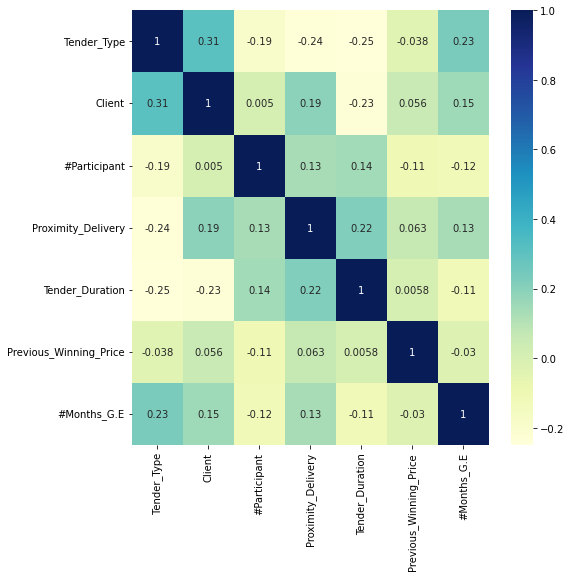

In [87]:
# import modules
import matplotlib.pyplot as mp
import pandas as pd
import seaborn as sb
  
# import file with data
data = model_final[[ ' Tender_Type',
       'Client', '#Participant', 'Proximity_Delivery',
       'Tender_Duration', 'Previous_Winning_Price', '#Months_G.E']]
  
# prints data that will be plotted
# columns shown here are selected by corr() since
# they are ideal for the plot
#print(data.corr())
  
# plotting correlation heatmap
plt.figure(figsize=(8,8)) 
dataplot = sb.heatmap(data.corr(), cmap="YlGnBu", annot=True) 
# displaying heatmap
mp.show()

### Logistic Regression

In [88]:
X=model_final[[ ' Tender_Type',
       'Client', '#Participant', 'Proximity_Delivery',
       'Tender_Duration', 'Previous_Winning_Price', '#Months_G.E']]

In [89]:
Y2 = list(model_final["DRL_Win_Flag"])

In [90]:
from sklearn.linear_model import LogisticRegression

In [94]:
# calculate heuristic class weighting
from sklearn.utils.class_weight import compute_class_weight
from sklearn.datasets import make_classification
# calculate class weighting
#weighting = compute_class_weight('balanced', [0,1], Y2)
#class_model = [0,1]
#weight_hue = dict(zip(class_model,weighting))
#print(weight_hue)
log_reg = LogisticRegression(random_state=0)#,class_weight=weight_hue)
log_reg.fit(X,Y2)
log_preds = log_reg.predict_proba(X)

In [95]:
win_prob_pred = []
for i in log_preds:
    win_prob_pred.append(i[1])
model_final["log_Pred"] = win_prob_pred

In [96]:
model_final.to_excel("Lognew_Preds3.xlsx")

In [97]:
win_prob_pred

[0.31878650974826356,
 0.3508483105270144,
 0.754335775111769,
 0.3182955476589945,
 0.35033336434044987,
 0.7541602369929143,
 0.14349120568535034,
 0.3177592661139051,
 0.3499853687442937,
 0.7541147008261071,
 0.14345545745033714,
 0.10946415201180237,
 0.32424996075296414,
 0.1654542988352994,
 0.22314212031362246,
 0.20039434606464562,
 0.3319849446516065,
 0.11802423799959272,
 0.15428990333766635,
 0.10946415201180237,
 0.32424996075296414,
 0.1654542988352994,
 0.22314212031362246,
 0.20039434606464562,
 0.3319849446516065,
 0.11802423799959272,
 0.15428990333766635,
 0.1945631072411789,
 0.1645699898331207,
 0.21088692723927568,
 0.19204333987375197,
 0.21288324295232197,
 0.20131031530665594,
 0.2639664062490353,
 0.5025587340239653,
 0.10168310118339531,
 0.1892174914702241,
 0.2058801591235745,
 0.196960709265329,
 0.25842095519735275,
 0.1441808942339238,
 0.1427016809915216,
 0.2695899396736612,
 0.11162855082663309,
 0.2587888040715629,
 0.2741151565428894,
 0.2705102501

In [79]:
model_final.columns

Index(['Identifier', 'DRL_Win_Flag', 'Form', 'Region', ' Tender_Type',
       'Client', '#Participant', 'Winning_Price', 'Proximity_Delivery',
       'Tender_Duration', 'Previous_Winning_Price', '#Months_G.E',
       'DRL_Bid_price', 'Prv_Cat', 'Predictions', 'Deviation', 'log_Pred'],
      dtype='object')

In [85]:
Client = pd.get_dummies(model_final["Client"])
Participant=pd.get_dummies(model_final["#Participant"])
Tender=pd.get_dummies(model_final[" Tender_Type"])

In [102]:
Client.columns = ["Top 10", "Bottom Left"]
Participant.columns = ["Low Competition","High Competition"]
Tender.columns = ["Regional","Others"]

In [109]:
log_X = pd.concat([Client,Participant,Tender,model_final[['Proximity_Delivery',
       'Tender_Duration',"Previous_Winning_Price", '#Months_G.E']]],axis=1)

In [108]:
log_Y = list(model_final["DRL_Win_Flag"])

In [127]:
log_X

,Top 10,Bottom Left,Low Competition,High Competition,Regional,Others,Proximity_Delivery,Tender_Duration,Previous_Winning_Price,#Months_G.E
0,0,1,0,1,1,0,0.266667,1.106742,0.36800,0.466667
1,0,1,0,1,0,1,0.266667,0.769663,0.36800,0.933333
2,1,0,1,0,0,1,0.533333,1.794944,0.41587,1.100000
4,0,1,0,1,1,0,0.266667,1.106742,0.67900,0.466667
5,0,1,0,1,0,1,0.266667,0.769663,0.67900,0.933333
...,...,...,...,...,...,...,...,...,...,...
177,0,1,0,1,1,0,9.733333,3.073034,12.50000,24.366667
178,0,1,1,0,0,1,2.333333,4.101124,0.22850,29.466667
179,0,1,0,1,1,0,1.833333,3.075843,0.23497,43.766667
180,0,1,0,1,1,0,4.033333,1.264045,0.24550,44.333333


In [132]:
log_reg1 = LogisticRegression(random_state=0)#,class_weight=weight_hue)
log_reg1.fit(log_X,log_Y)
log_reg1.coef_
#log_reg1.intercept_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([[ 0.2097457 , -0.2012764 ,  1.0285586 , -1.02008929,  0.02577962,
        -0.01731032,  0.09008254, -0.49315123, -0.00800608, -0.004028  ]])

In [126]:
log_X.columns

Index(['Top 10', 'Bottom Left', 'Low Competition', 'High Competition',
       'Regional', 'Others', 'Proximity_Delivery', 'Tender_Duration',
       'Previous_Winning_Price', '#Months_G.E'],
      dtype='object')

In [124]:
log_df = pd.DataFrame({"Features":log_X.columns,"Coefficients":(log_reg1.coef_)[0]})
log_df

,Features,Coefficients
0,Top 10,0.209746
1,Bottom Left,-0.201276
2,Low Competition,1.028559
3,High Competition,-1.020089
4,Regional,0.025780
5,Others,-0.017310
6,Proximity_Delivery,0.090083
7,Tender_Duration,-0.493151
8,Previous_Winning_Price,-0.008006
9,#Months_G.E,-0.004028


In [115]:
log_df.to_excel("LogisticCoefficient.xlsx")

In [122]:
grad_reg.feature_importances_

array([9.21308826e-05, 3.31785860e-04, 6.51870314e-03, 7.77763428e-03,
       1.11097872e-02, 9.65486660e-01, 8.68329851e-03])

In [123]:
X.columns

Index(['Client', ' Tender_Type', 'Proximity_Delivery', '#Participant',
       'Tender_Duration', 'Previous_Winning_Price', '#Months_G.E'],
      dtype='object')

In [129]:
log_reg.coef_

array([[-0.01764674, -0.3825706 , -1.82973892,  0.08384593, -0.48433114,
        -0.00727248, -0.00336272]])

In [130]:
X.columns

Index(['Client', ' Tender_Type', 'Proximity_Delivery', '#Participant',
       'Tender_Duration', 'Previous_Winning_Price', '#Months_G.E'],
      dtype='object')